### Notes
The Fresnel Transfer Function (TF) Propagator is given by the equation (CFO 5.2):
$$
H(f_x, f_y) = e^{j k z} \exp[- j \pi \lambda z (f_x^2 + f_y^2)]
$$

The focus transmittance function is approximately (CFO 6.9):
$$
t_{A}(x, y) = \exp[-j \frac{k}{2 z_f} \left(x^2 + y^2 \right)]
$$

### Incoherent Imaging

To test, we will start with a square pupil function (CFO 7.8)
$$
P(x, y) = \text{rect}\left(\frac{x}{2 w_{\text{XP}}}\right) \text{rect}\left(\frac{y}{2 w_{\text{XP}}}\right)
$$
The coherent transfer function is (CFO 7.9):
$$
H(f_U, f_V) = \text{rect}\left(\frac{-\lambda z_{\text{XP}} f_U}{2 w_{\text{XP}}} \right)
\text{rect}\left(\frac{-\lambda z_{\text{XP}} f_V}{2 w_{\text{XP}}} \right)
$$

### Bench Measurments
The f-number of a lens is the focal length divided by aperture diameter:
* 50mm Lens:  $f/\# = 2.0$
* 400mm Lens: $f/\# = 16.0$

From CFO section 7.2.3 the constraint on length $L$ given a number of samples $M$ is (CFO 7.19):
$$
L \leq M \frac{\lambda(f/\#)}{2}
$$

For the above lenses with a 490nm wavelength LED and a 500x500 pixel image, this means:
* 50 mm Lens: $L \leq 2.45 \cdot 10^{-4} \text{m}$
* 400 mm Lens: $L \leq 1.96 \cdot 10^{-3} \text{m}$

### TODO LIST

* Fix Axex Labels in `image_plane` object to account for Length:
* Adjust `plot()` function to automatically zoom in on image region of interest (to see small fringes)
* Revert bench measurement change to L

In [2]:
import numpy as np
import numpy.fft as fft #shorthand for fft.fft2 and fft.fftshift
from dataclasses import dataclass 
#import poppy #optical simulation library: not as many uses as I hoped, more for telescope simulation
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable #for making nice colorbars

In [12]:
@dataclass
class image_plane:
    #dataclass representing a 2D image plane with a label
    #simplifies plotting, labeling, and propagating images
    #TODO: fix axes labels to reflect actual bench measurements
    image: np.ndarray
    label: str
    length: float = 2.0 #assuming image axes from (-L/2, L/2)
    
    def plot(self, fig=None, ax=None, bounds="auto", label=None, savefig=False, show=True):
        if ax is None:
            plt.figure("{}".format(self.label), figsize=(7,7))
            ax = plt.gca()
        if fig is None:
            fig = plt.gcf()
        divider = make_axes_locatable(ax)
        plot_args = {'cmap':'gray', 'extent':[-0.5*self.length, 0.5*self.length, -0.5*self.length, 0.5*self.length]}
        if bounds.lower()=='full':
            plot_args['vmin'] = 0.
            plot_args['vmax'] = 1.
            tick_values = [0, 0.5, 1]
        else:
            tick_values = None
        im = ax.imshow(np.abs(self.image)**2, **plot_args)
        ax.set_title(self.label)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical', ticks=tick_values)
        label = self.label if label is None else label
        if savefig:
            plt.savefig("./Images/{}.png".format(label))
        if show:
            plt.draw()

    def zoom(self):
        sample_density = self.image.shape[0]
        midpoint = sample_density // 2
        buffer = sample_density // 30
        line_samples = [midpoint, midpoint + buffer, midpoint - buffer]
        bound = 0
        #iterate over a few lines to reduce chance of overcropping
        for line_num in line_samples:
            vert_line = self.image[line_num,:]
            horiz_line = self.image[:,line_num]
            vert_threshold = np.max(vert_line) / 20
            horiz_threshold = np.max(horiz_line) / 20
            #boundary should be the largest index that can be seen that doesn't contain a significant percent of the image intensity.
            bound = max([bound, np.argmax(vert_line > vert_threshold), np.argmax(horiz_line > horiz_threshold)])
        if bound > buffer:
            cropped_im = self.image[bound-buffer:-1*(bound-buffer), (bound-buffer):-1*(bound-buffer)]
        else:
            print("Could not crop image.")
            return self
        reduced_length = (sample_density - 2*bound) / (sample_density) * self.length
        return image_plane(cropped_im, "{} (Cropped)".format(self.label), length=reduced_length)
    
    def __add__(self, other):
        return image_plane(self.image + other.image, "{} + {}".format(self.label, other.label))
    
#Plotting Functions
def plot_images(im_list, bounds="auto"):
    num_ims = len(im_list)
    fig, ax = plt.subplots(1, num_ims, figsize = (15, 15*num_ims))
    for idx, im in enumerate(im_list):
        im.plot(fig, ax[idx], bounds=bounds, savefig=False, show=False)
    plt.show()

In [13]:
#Functions for propagating images
def point_distribution(sample_density=100):
    #create a uniform distribution of (sample_density^2) 2D coordinates
    return np.array(np.meshgrid(np.linspace(-1, 1, sample_density), np.linspace(-1, 1, sample_density)))

def fresnel_TF_prop(U1, L, z, wavelength=1, label=None):
    # simulate the optical propagation of an input plane based on the Frenel Transfer Function
    #based on CFO p63
    #U1: Input image plane object, a set of coordinates that will be propagated
    #z: propagation distance
    #L: length of one side of source and observation plane
    sample_density = U1.image.shape[0]
    dx = L / sample_density
    #k = 2 * np.pi / wavelength
    frequency_coords = np.arange(-1/(2*dx), 1/(2*dx), 1/L) 
    freq_dist = np.array(np.meshgrid(frequency_coords, frequency_coords))
    #freq_dist = 1 / (2* point_distribution(sample_density)) #create frequency sample distribution
    freq_magnitude = np.sum(freq_dist**2, axis=0) 
    TF_arg = -1j * np.pi * wavelength * z * freq_magnitude #argument for the fresnel TF
    H = fft.fftshift(np.exp(TF_arg)) #created shifted transfer function
    U1_fft = fft.fft2(fft.fftshift(U1.image)) #shift & fft input (source) field
    U2 = fft.ifftshift(fft.ifft2(U1_fft * H)) # output (observed) field obtained by multiplying FFT by H
    #set a default label if none specified
    label = "{} (Fresnel Propagated)".format(U1.label) if label is None else label
    return image_plane(U2, label, L)

def pupil_func(U1, lens_radius = 1):
    return np.sqrt(np.sum(U1**2), axis=0) / lens_radius <= 1

def lens_transmittance_fxn(U1, wavelength, f):
    #CFO examples p96
    k = 2 * np.pi / wavelength
    return pupil_func(U1) * np.exp(-1j * k / (2*f) * np.sum(in_coords**2, axis=0))

def focus(U1, zf, wavelength=1., label=None):
    #focus(+) or defocus(-) an image with a focal length of +/- zf
    #from MATLAB examples p94
    # U1: input (source) image
    # zf: focal length of lens
    uniform_dist = point_distribution(U1.image.shape[0])
    exp_arg = (-1j * np.pi / (zf * wavelength)) * np.sum(uniform_dist**2, axis=0)
    focused = U1.image * np.exp(exp_arg)
    #set a default label if none specified
    label =  "{} (Focused)".format(U1.label) if label is None else label
    return image_plane(focused, label)

def circ(point_grid, radius):
    return np.array(np.sqrt(np.sum(point_grid**2, axis=0)) < radius).astype(float)

def OTF(U1, L, zxp, wxp, wavelength=1., label=None):
    #generate Optical Transfer Function (CFO 7.24) for simulated imaging
    #based on CFO p129, Goodman p141
    #wxp: exit pupil radius
    #zxp: exit pupil distance
    #L: image plane side length
    assert(U1.image.shape[0] == U1.image.shape[1]) #must be square image
    sample_interval = L / U1.image.shape[0]
    freq_sample_range = np.arange(-1/(2*sample_interval), 1/(2*sample_interval), 1/L)
    freq_sample = np.array(np.meshgrid(freq_sample_range, freq_sample_range))
    f0 = wxp / (wavelength * zxp) #coherent cutoff
    H = circ(freq_sample, f0)
    OTF_result = fft.ifft2(np.abs(fft.fft2(fft.fftshift(H)))**2)
    OTF_result = abs(OTF_result / OTF_result[0,0]) #normalization condition CFO 7.25 (Goodman p138)
    #set a default label if none specified
    label = "{} (OTF)".format(U1.label) if label is None else label
    return image_plane(OTF_result, label)

def convolution(U1, U2, label=None):
    G1 = fft.fft2(fft.fftshift(U1.image))
    G2 = fft.fft2(fft.fftshift(U2.image))
    result = fft.ifftshift(fft.ifft2(G1*G2))
    label = "{}*{}".format(U1.label, U2.label) if label is None else label
    return image_plane(result, label)

def incoherent_image(U1, L, zxp, wxp, wavelength=1., label=None):
    #simulate an incoherent image based on input image
    #wxp: exit pupil radius
    #zxp: exit pupil distance
    #L: image plane side length
    OTF_result = OTF(U1, L, zxp, wxp, wavelength, label="")
    Ig = U1.image / np.max(U1.image.flatten()) #ideal image
    Gg = fft.fft2(fft.fftshift(Ig)) #FT of ideal image
    Gi = Gg * OTF_result.image #multiplt FTs
    Ii = np.real(fft.ifftshift(fft.ifft2(Gi)))
    Ii *= (Ii > 0) #set negative parts to zero
    #set a default label if none specified
    label = "{} (Incoherent Image)".format(U1.label) if label is None else label
    return image_plane(np.sqrt(Ii), label)

In [14]:
#Gaussian Beam in 2D
dist = np.array(np.meshgrid(np.linspace(-1, 1, 500), np.linspace(-1, 1, 500)))
gaus = image_plane(np.exp(-np.sum(dist**2, axis=0)/0.25), "Gaussian")
#square beam in 2D
diamond = image_plane(np.array(np.sum(np.abs(dist), axis=0) < 0.5).astype(float), "Diamond")
sq = image_plane(np.array(
                 np.logical_and(abs(dist[1,:,:]) < np.ones_like(dist[1,:,:])*0.5,
                                abs(dist[0,:,:]) < np.ones_like(dist[0,:,:])*0.5)).astype(float),
                 "Square")        
dot = image_plane(circ(point_distribution(500), 0.3), "Dot")
point = image_plane(circ(point_distribution(500), 0.05), "Point")
const = image_plane(np.ones_like(point_distribution(3000))[0], "Constant")

### Simple Test
To simplify the simulation and work up, I will assume a linear polarizer is in place of of the QWP. Then we can just look at the PSF for a birefringent lens. The linear polarizer will be at 45 degrees with respect to the polarizing beam splitter, so the overall effect is that we will have complete overlap of the two beams in our interferometer. We will generate an ideal image from a point which has projected forward to F1 by a displacement $+d$, along with a second ideal image propagated by $-d$ (backward) to the point F2. These two images will be propegated with `incoherent_image()` to the point IM, and this is our PSF for this birefringent lens.

![alt text](Images/BRL_diagram.png "BRL Diagram")

The simulated image is the convolution of the PSF(dot above) with the ground truth image.
We will want to add in magnification, but that will just be a factor in the denominator of the phase.

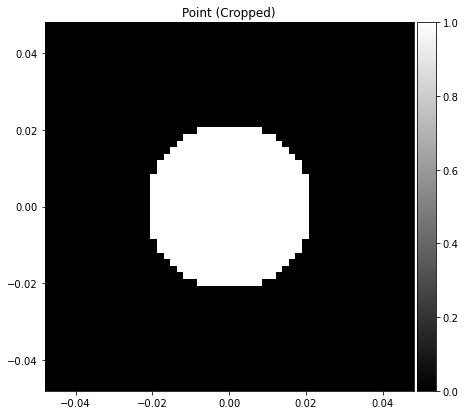

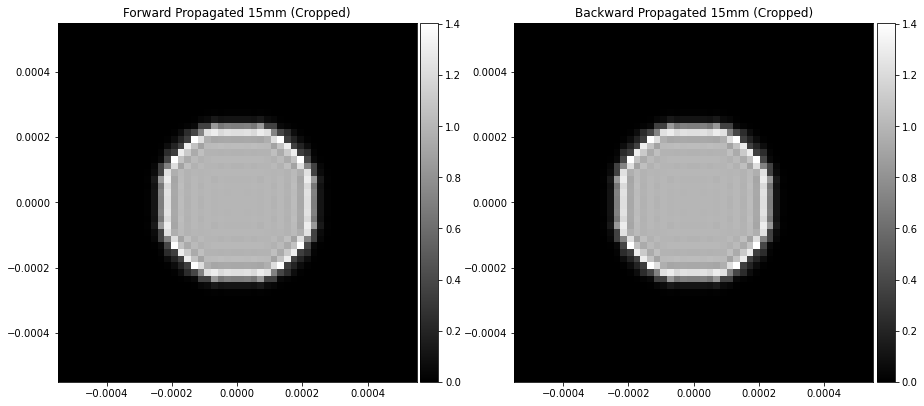

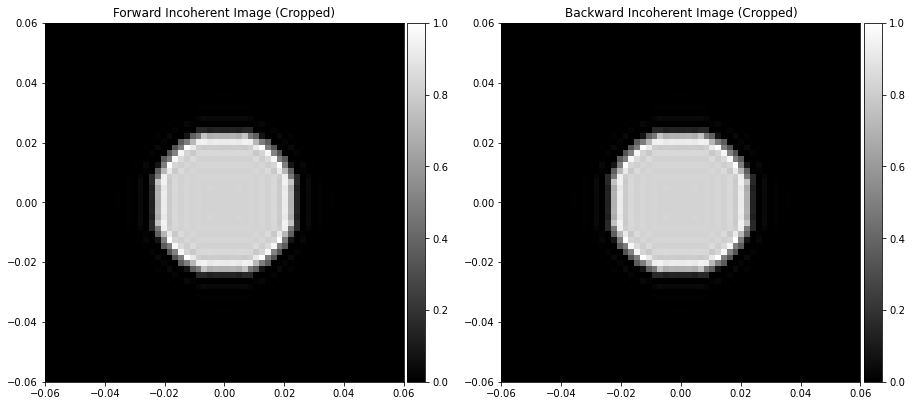

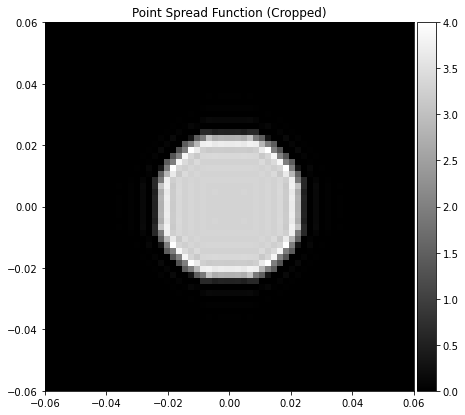

In [16]:
#approximate measurements of parameters in my optical setup.
#I don't notice any interference pattern with these parameters.
bench_measurements = {"wavelength":490e-9, #490nm
                      "L":2.5e-2,#2.5cm #REVERT
                      "z_total":415e-3, #~415mm
                      "wxp":1.25e-2, #1.25cm
                      "displacement":15e-3 #~15mm
                     }
point = image_plane(circ(point_distribution(500), 0.05), "Point")
point.zoom().plot()
#We propagate a constant instead of a dot here for testing purposes. It may be easier to see interference this way. 
p_forward  = fresnel_TF_prop(point, bench_measurements["L"], 
                             bench_measurements["displacement"],
                             wavelength=bench_measurements["wavelength"],
                             label="Forward Propagated 15mm")
p_backward = fresnel_TF_prop(point, bench_measurements["L"],
                             -1*bench_measurements["displacement"],
                             wavelength=bench_measurements["wavelength"],
                             label="Backward Propagated 15mm")
inc_p_forward  = incoherent_image(p_forward, bench_measurements["L"],
                        bench_measurements["z_total"]-bench_measurements["displacement"],
                        bench_measurements["wxp"], wavelength=bench_measurements["wavelength"],
                        label="Forward Incoherent Image")
inc_p_backward = incoherent_image(p_backward, bench_measurements["L"],
                        bench_measurements["z_total"]+bench_measurements["displacement"],
                        bench_measurements["wxp"], wavelength=bench_measurements["wavelength"],
                        label="Backward Incoherent Image")
psf = image_plane((inc_p_forward + inc_p_backward).image, "Point Spread Function")
#cv = convolution(psf, const, label = "Constant * PSF")
plot_images([p_forward.zoom(), p_backward.zoom()])
plot_images([inc_p_forward.zoom(), inc_p_backward.zoom()])
psf.zoom().plot()
#plot_images([psf, cv])


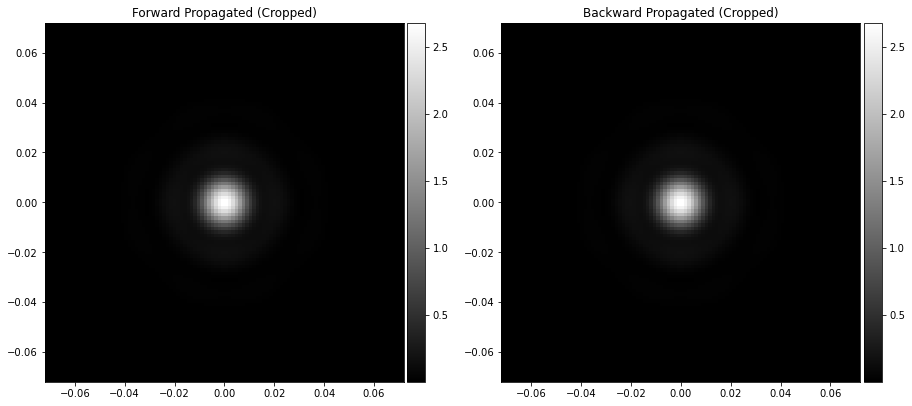

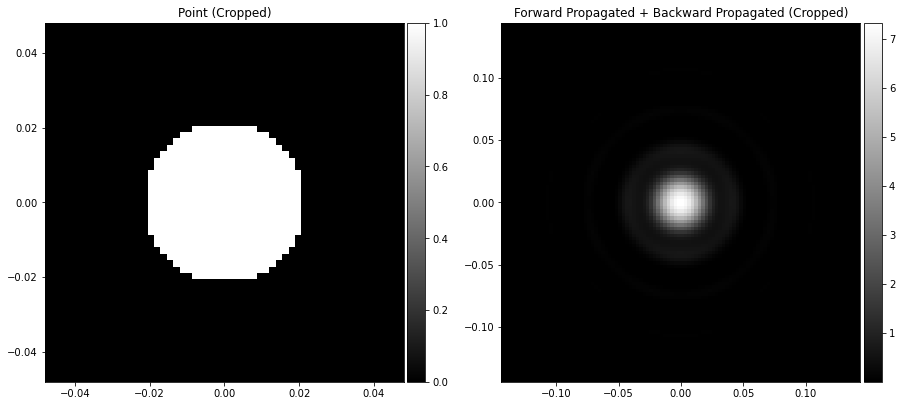

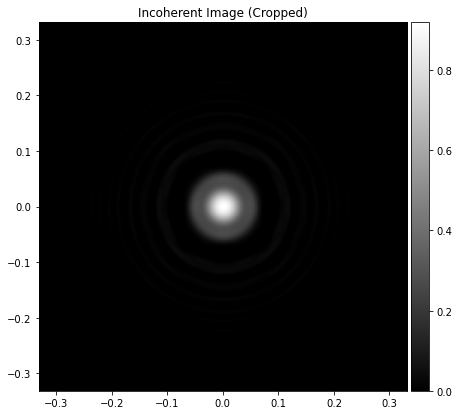

In [17]:
#Plotting Some images with nonphysical parameters to see the interference effects.
p1 = fresnel_TF_prop(point, 1, 0.001, label="Forward Propagated")
p2 = fresnel_TF_prop(point, 1, -0.001, label="Backward Propagated")
plot_images([p1.zoom(),p2.zoom()])
plot_images([point.zoom(), (p1+p2).zoom()])
inc_point = incoherent_image(p1+p2, 1, 1, 5e-6, wavelength=5e-8, label="Incoherent Image")
inc_point.zoom().plot()

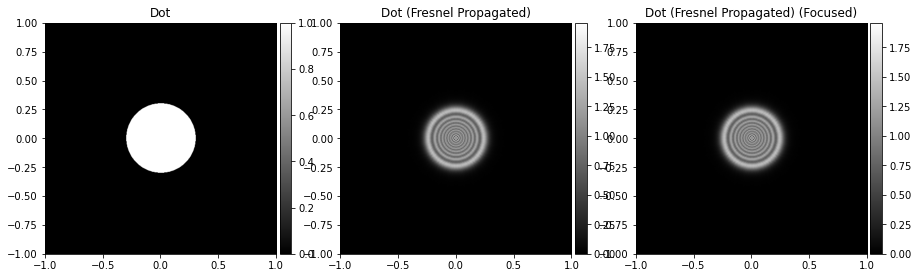

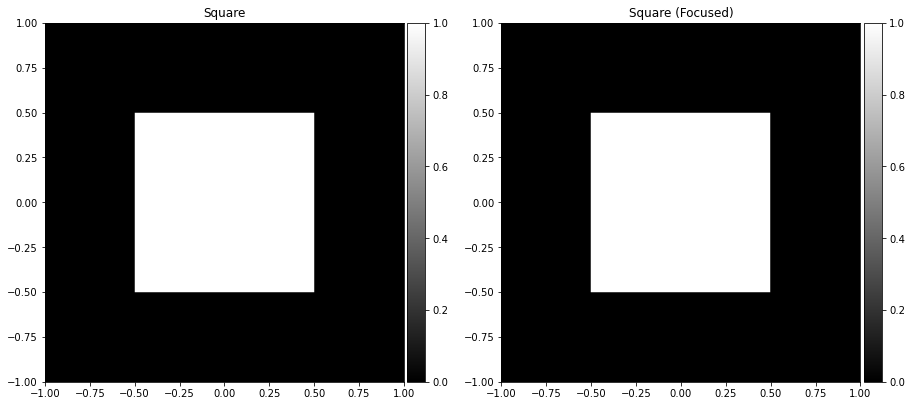

In [7]:
prop = fresnel_TF_prop(dot, 2, 0.005)
foc = focus(prop, 0.5)
plot_images([dot, prop, foc])
plot_images([sq, focus(sq, 0.2)])

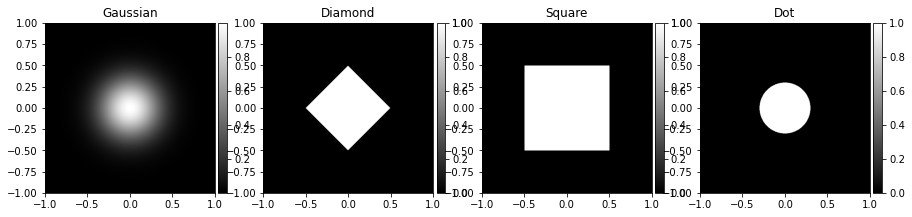

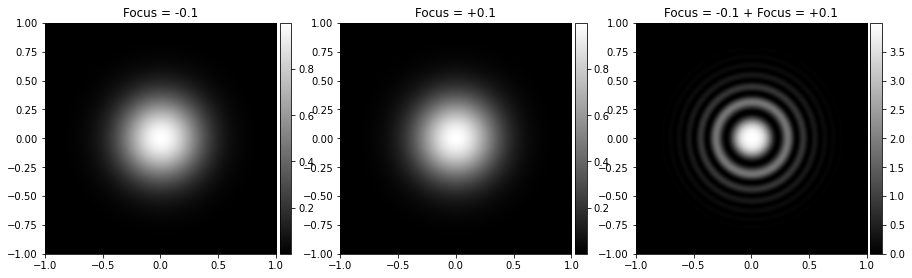

In [8]:
plot_images([gaus, diamond, sq, dot])
f1 = focus(gaus, -0.1, label="Focus = -0.1")
f2 = focus(gaus, 0.1, label="Focus = +0.1")
plot_images([f1, f2, f1+f2])

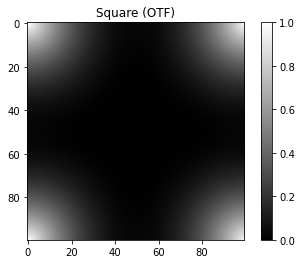

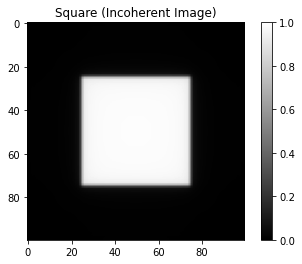

In [56]:
OTF(sq, 0.3, 1, 5e-6, wavelength=5e-8).plot()
incoherent_image(sq, 0.3, 1, 5e-6, wavelength=5e-8).plot()

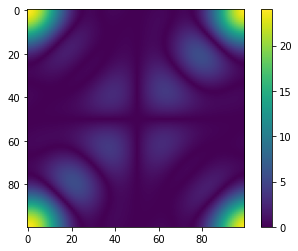

In [37]:
plt.imshow(np.abs(np.real(np.fft.fft2(dot))))
plt.colorbar()

### References
CFO: Computational Fourier Optics: A MATLAB Tutorial

In [17]:
test = (0, 1)
a = [*test, *test]
a

[0, 1, 0, 1]